<a href="https://colab.research.google.com/github/Xixianghu202124213/Capstone/blob/main/ARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF
import numpy as np
%matplotlib inline
import csv
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA

from sklearn.metrics import mean_squared_error, r2_score


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


           MATERIAL_NUMBER PLANT  QUANTITY
DATE                                      
2015-01-05               H    X2         0
2015-01-06               H    X2         5
2015-01-07               H    X2         2
2015-01-08               H    X2       260
2015-01-09               H    X2         9
...                    ...   ...       ...
2020-01-01               H    X2         0
2020-01-02               H    X2        33
2020-01-03               H    X2        27
2020-01-04               H    X2         0
2020-01-05               H    X2         0

[1827 rows x 3 columns]


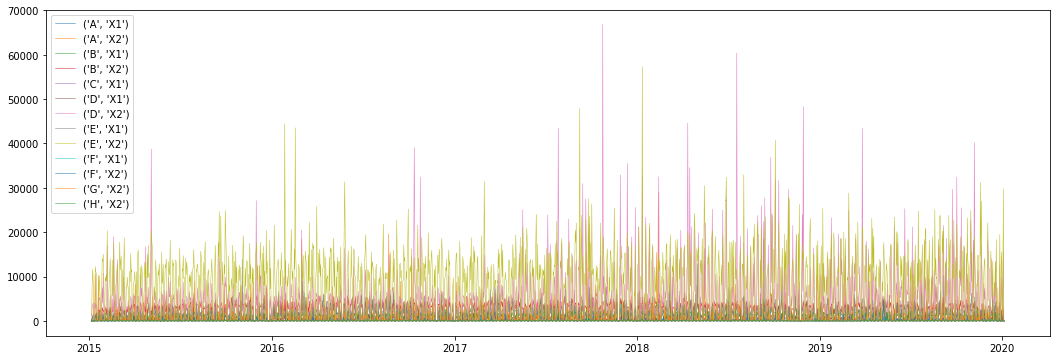

In [ ]:

csvfile = open('/content/drive/MyDrive/Data/historical_orders.csv','r')
reader = [each for each in csv.DictReader(csvfile, delimiter=';')]
df = pd.DataFrame(reader)

df["DATE"]=pd.to_datetime(df["DATE"],format="%d.%m.%Y")
df.set_index('DATE',inplace=True)
groups=df.groupby(["MATERIAL_NUMBER","PLANT"])
group_list=list(groups)
group_list
from pandas import DataFrame
ax,fig=plt.subplots(figsize=(18,6))
series=DataFrame()
for key,df in groups:
    series=df.copy()
    series.iloc[:,2]=series.iloc[:,2].astype(int)
    plt.plot(series.index,series.iloc[:,2],linewidth=0.5,label=key)
    plt.legend()
   # print(type(df))
print(series)

#for i in range(len(group_list)):


In [ ]:
GDP=pd.read_csv('/content/drive/MyDrive/Data/GDP.csv')
GDP.columns
GDP.set_index('0',inplace=True)
GDP=GDP[(GDP.index>='2015-01-05')&(GDP.index<='2020-01-05')]
GDP.index.name=None

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
workday=pd.read_csv('/content/drive/MyDrive/Data/workday.csv')
train_size=int(len(df)*0.9)
workday.set_index('DATE',inplace=True)
workday.index=workday.index.astype('datetime64[ns]')
work_train=workday[0:train_size]
work_test=workday[train_size:]

In [ ]:
def ARIMA_Model(timeseries,order):
    model = ARIMA(timeseries,exog=work_train,order=order)
    return model.fit()

In [ ]:
def log(timeseries):
  timeseries_log=np.log(timeseries).replace(float("-inf"), 0)
  return timeseries_log

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_model_method2(timeseries, arima_order):
  train_size = int(len(timeseries)*0.9)
  train, test = timeseries[0:train_size],timeseries[train_size:]
  rmse=float("inf")
  try:
    #print(rmse)
    model = ARIMA_Model(train,arima_order)
    fit_seq = model.fittedvalues
    rmse = mean_squared_error(train, fit_seq,squared=False)
    #print(rmse,'##########')
    
  except:
    pass
  return rmse

In [ ]:
def gridsearch(timeseries):
  series_pdq=[]
  series_mse=[]
  train_size=int(len(timeseries)*0.9)
  train=timeseries[0:train_size]
  test=timeseries[train_size:]
  best_score = float("inf")
  best_pdq=None
  for p in range(8):
    for d in range(3):
        for q in range(8):  
          order=(p,d,q)
          #print(str(order))
          try:
            rmse=evaluate_model_method2(timeseries,order)
            if rmse<best_score:
              
              best_score=rmse
              best_pdq=order
              print("RMSE",best_pdq,best_score)
          except:
              pass
  return best_pdq

In [ ]:
def model_fit(seasonal,trend,residual,tr_pdq,re_pdq):
  train_size=int(len(trend)*0.9)
  test=seasonal[train_size:]

  tr_p,tr_d,tr_q=tr_pdq[0],tr_pdq[1],tr_pdq[2]
  trend_model = ARIMA_Model(trend[0:train_size],(tr_p,tr_d,tr_q))

  trend_fit_seq = trend_model.fittedvalues

  re_p,re_d,re_q=re_pdq[0],re_pdq[1],re_pdq[2]
  residual_model = ARIMA_Model(residual[0:train_size],(re_p,re_d,re_q))
  residual_fit_seq = residual_model.fittedvalues

  fit_seq = pd.Series(seasonal[0:train_size], index=seasonal[0:train_size].index)
  fit_seq = fit_seq.add(trend_fit_seq, fill_value=0)
  fit_seq = fit_seq.add(residual_fit_seq, fill_value=0)

  trend_predict_seq = trend_model.predict(start='2019-07-07',end='2019-08-07',exog=work_test[0:32],dynamic=True)
  residual_predict_seq = residual_model.predict(start='2019-07-07',end='2019-08-07',exog=work_test[0:32],dynamic=True)
  seasonal_predict_seq=seasonal['2018-07-01':'2018-08-01']
  
  seasonal_predict_seq.index = test[0:32].index
  predict_seq = pd.Series(seasonal_predict_seq, index=seasonal_predict_seq.index)
  
  predict_seq = predict_seq.add(trend_predict_seq, fill_value=0)
  print(len(predict_seq))
  predict_seq = predict_seq.add(residual_predict_seq, fill_value=0)


  return fit_seq,predict_seq


In [ ]:
def pre_month(sequence,title,test,tr_pdq,re_pdq):
  rmse = mean_squared_error(test[0:32], sequence,squared=False)
  wape=WAPE(sequence,test[0:32])
  plt.figure(figsize=(20, 8))
  plt.plot(sequence, color='red', label='predict_seq')
  plt.plot(test[0:32], color='blue', label='test_seq')
  plt.legend(loc='best')
  plt.title("Trend Model:"+str(tr_pdq) +" Residual Model: "+str(re_pdq)+"  RMSE: %f"%(rmse,))
  plt.suptitle(str(title)+"MONTH")
  name="/content/drive/MyDrive/Colab Notebooks/LSE/Capstone/ARIMAX_Plot(Workday)/"+str(title)+'_predict(Month).png'
  plt.savefig(name)
  plt.show()
  return rmse,wape


In [ ]:
def pre_week(sequence,title,test,tr_pdq,re_pdq):
  rmse = mean_squared_error(test[0:8], sequence,squared=False)
  wape=WAPE(sequence,test[0:8])
  plt.figure(figsize=(20, 8))
  plt.plot(sequence, color='red', label='predict_seq')
  plt.plot(test[0:8], color='blue', label='test_seq')
  plt.legend(loc='best')
  plt.title("Trend Model:"+str(tr_pdq) +" Residual Model: "+str(re_pdq)+"  RMSE: %f"%(rmse,))
  plt.suptitle(str(title)+"WEEK")
  name="/content/drive/MyDrive/Colab Notebooks/LSE/Capstone/ARIMAX_Plot(Workday)/"+str(title)+'_predict(week).png'
  plt.savefig(name)
  plt.show()
  return rmse,wape

In [ ]:
def fit_plot(sequence,title,train,tr_pdq,re_pdq):
  train_size=int(len(train)*0.9)
  #train_size=1200
  #train=train[0:train_size]
  rmse = mean_squared_error(train, sequence,squared=False)
  wape=WAPE(sequence,train)
  plt.figure(figsize=(20, 8))
  plt.plot(sequence[len(sequence)-365:len(sequence)], color='red', label='fit_seq')
  plt.plot(train[len(sequence)-365:len(sequence)], color='blue', label='original_seq')
  plt.legend(loc='best')
  plt.title("Trend Model:"+str(tr_pdq) +" Residual Model: "+str(re_pdq)+"  RMSE: %f"%(rmse,))
  plt.suptitle(title)
  name="/content/drive/MyDrive/Colab Notebooks/LSE/Capstone/ARIMAX_Plot(Workday)/"+str(title)+'_month_simulation.png'
  plt.savefig(name)
  plt.show()
  return rmse,wape

In [ ]:
def WAPE(fit,seq):
  x=(fit-seq).abs().sum()/(seq.abs().sum())
  return x

In [ ]:
def recover(series):
  recover_seq= np.exp(series)
  recover_seq.dropna(inplace=True)
  return recover_seq

In [ ]:
workday=pd.read_csv('/content/drive/MyDrive/Data/workday.csv')
workday.reset_index()

,index,DATE,Workday
0,0,2015-01-05,1
1,1,2015-01-06,1
2,2,2015-01-07,1
3,3,2015-01-08,1
4,4,2015-01-09,1
...,...,...,...
1822,1822,2020-01-01,0
1823,1823,2020-01-02,1
1824,1824,2020-01-03,1
1825,1825,2020-01-04,0


RMSE (0, 0, 0) 59.8677463176251
RMSE (0, 0, 1) 41.99093986895953
RMSE (0, 0, 3) 31.23272397359717
RMSE (0, 0, 4) 31.209811118753617
RMSE (0, 0, 5) 30.820484944021857
RMSE (0, 0, 7) 22.70376163771373
RMSE (1, 0, 6) 22.703677834142603
RMSE (2, 0, 6) 22.703594744301984
RMSE (2, 0, 7) 22.7027690220147
RMSE (3, 0, 7) 22.70123211071342
RMSE (5, 0, 6) 22.694269012280433
RMSE (5, 0, 7) 22.691024590097076
RMSE (6, 0, 7) 22.649218039918434
RMSE (0, 0, 0) 142.15108169484517
RMSE (0, 0, 1) 118.38550207869103
RMSE (0, 0, 2) 111.87679338981516
RMSE (1, 0, 6) 98.54441762957649
32


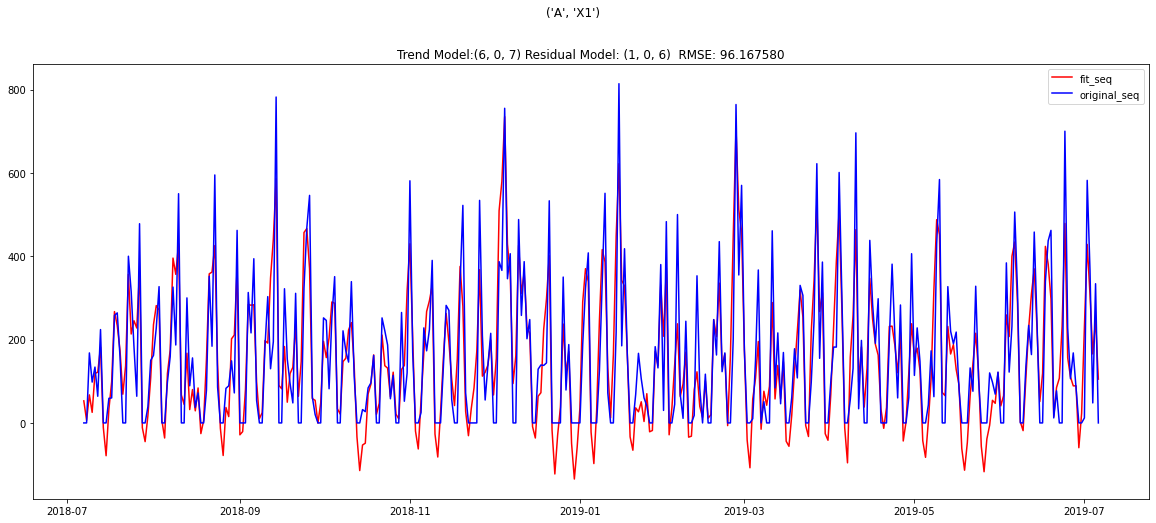

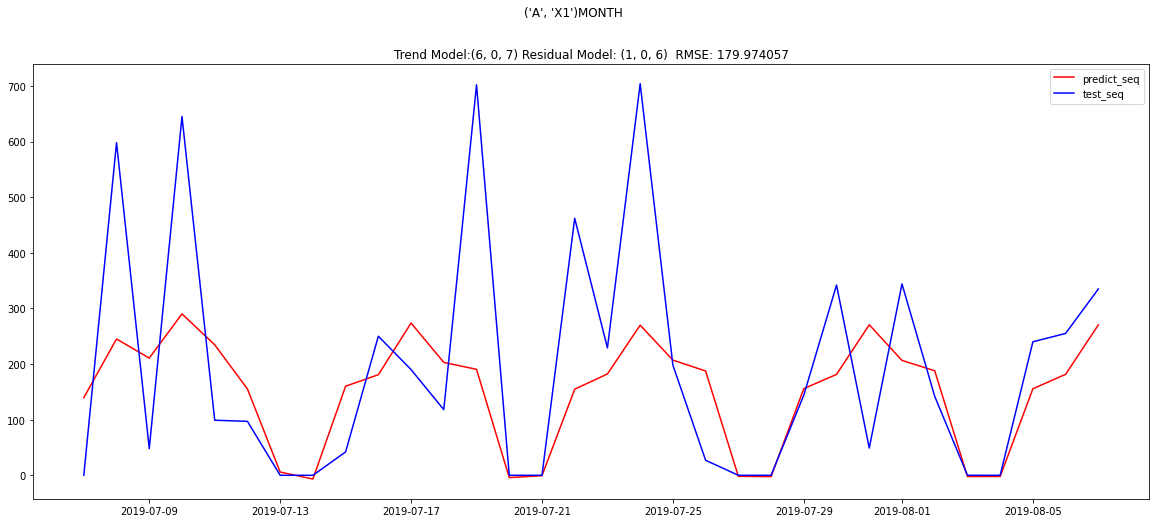

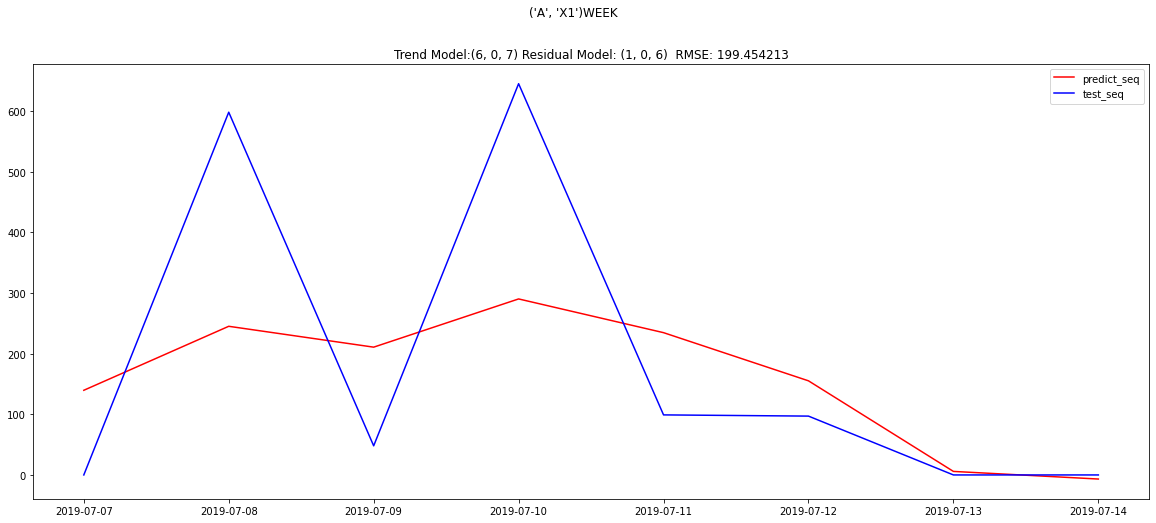

RMSE (0, 0, 0) 632.9553051415082
RMSE (0, 0, 1) 432.2137958291177
RMSE (0, 0, 3) 327.86905824084533
RMSE (1, 0, 0) 312.68500573745933
RMSE (1, 0, 1) 310.9833826509581
RMSE (1, 0, 2) 310.5557614060744
RMSE (1, 0, 3) 308.88259680467274
RMSE (1, 0, 4) 291.05204473206237
RMSE (1, 0, 5) 282.8931078022841
RMSE (1, 0, 6) 230.41213119145416
RMSE (2, 0, 6) 230.34831210495977
RMSE (4, 0, 6) 230.17731749041158
RMSE (5, 0, 6) 230.06263455318103
RMSE (6, 0, 6) 229.78022919852154
RMSE (7, 0, 6) 229.7731206103274
RMSE (0, 0, 0) 1433.7083570279544
RMSE (0, 0, 1) 1183.3676703609233
RMSE (0, 0, 2) 1119.8092752722357
RMSE (6, 0, 1) 1051.7921056686937
RMSE (7, 0, 1) 1046.7398875430354
32


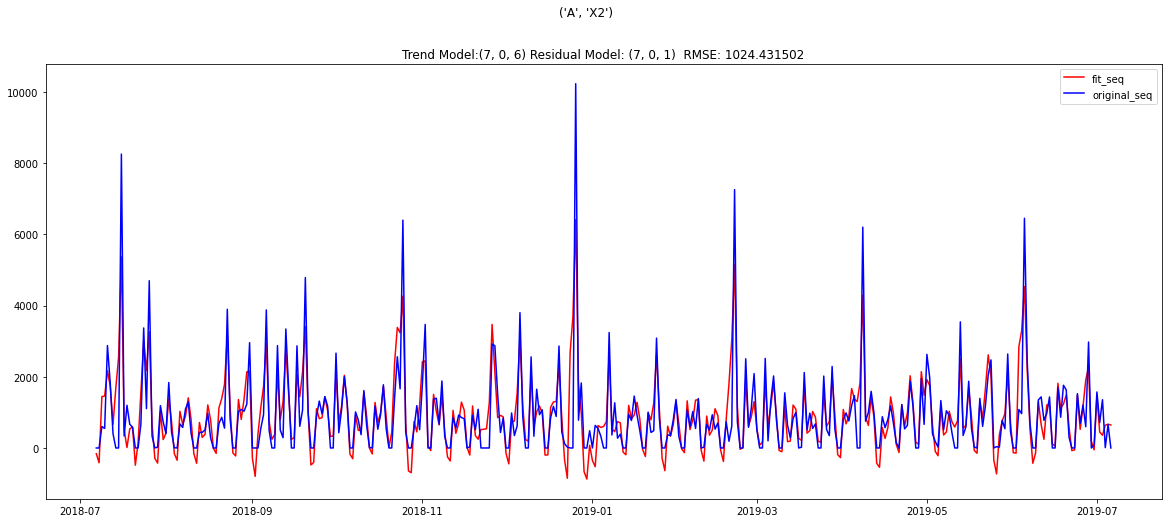

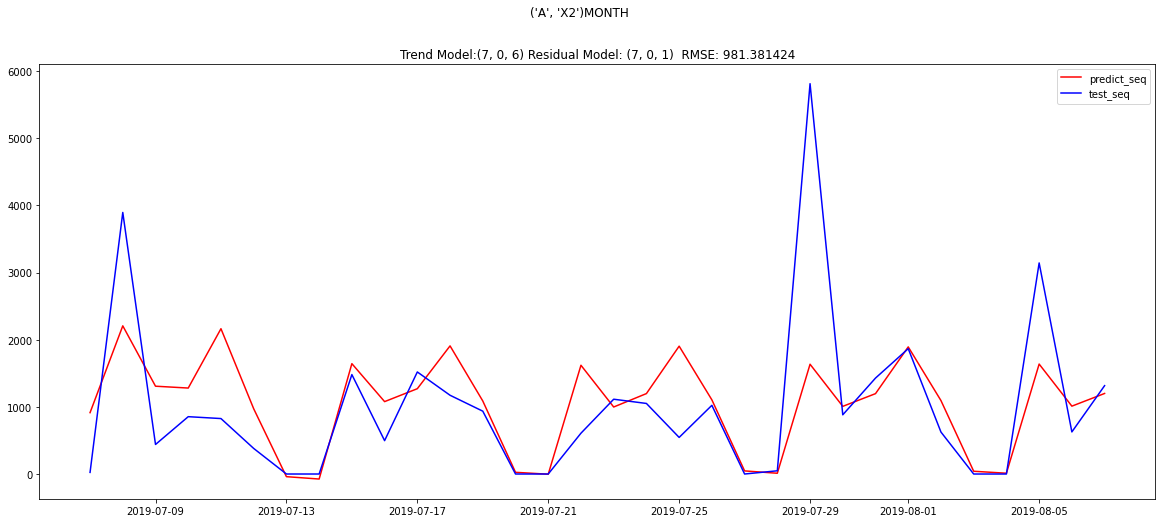

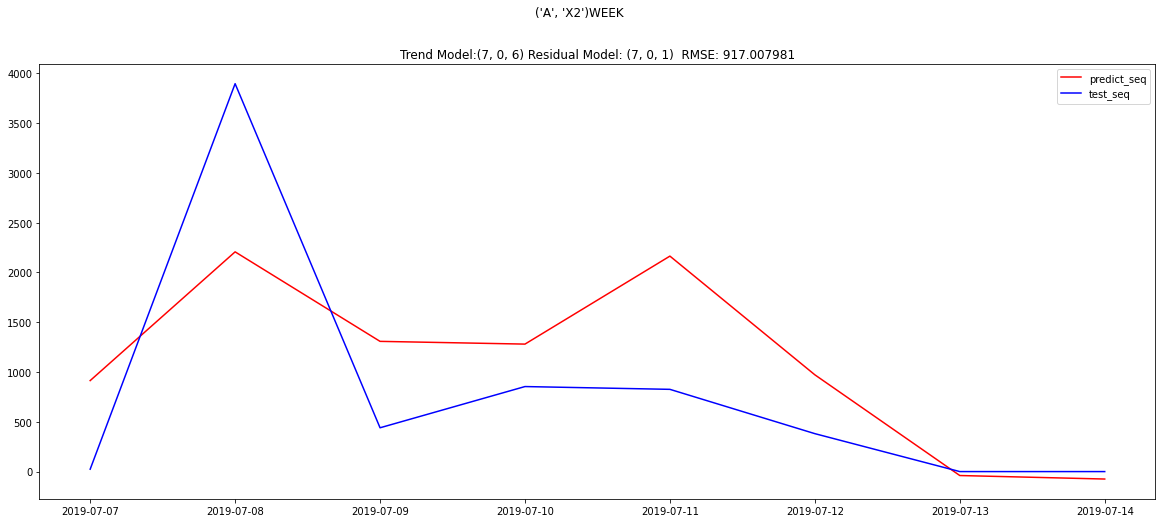

RMSE (0, 0, 0) 321.869819278833
RMSE (0, 0, 1) 209.96382292883055
RMSE (0, 0, 5) 138.41868089025638
RMSE (1, 0, 0) 132.90863764281792
RMSE (1, 0, 1) 131.53449518038573
RMSE (1, 0, 2) 131.14672370199423
RMSE (1, 0, 3) 131.1453458738799
RMSE (1, 0, 4) 126.32232293713683
RMSE (1, 0, 5) 120.726302307797
RMSE (1, 0, 6) 99.62194571094712
RMSE (1, 0, 7) 98.3520786991636
RMSE (2, 0, 7) 98.14982780970827
RMSE (3, 0, 7) 98.1122734391758
RMSE (4, 0, 7) 98.04384589538941
RMSE (6, 0, 7) 98.03081676678377
RMSE (0, 0, 0) 604.3990267237999
RMSE (0, 0, 1) 513.2312265507271
RMSE (0, 0, 2) 479.05182755351035
RMSE (3, 0, 1) 447.2285871597638
RMSE (6, 0, 1) 439.84424208579077
RMSE (7, 0, 1) 438.2527023241648
32


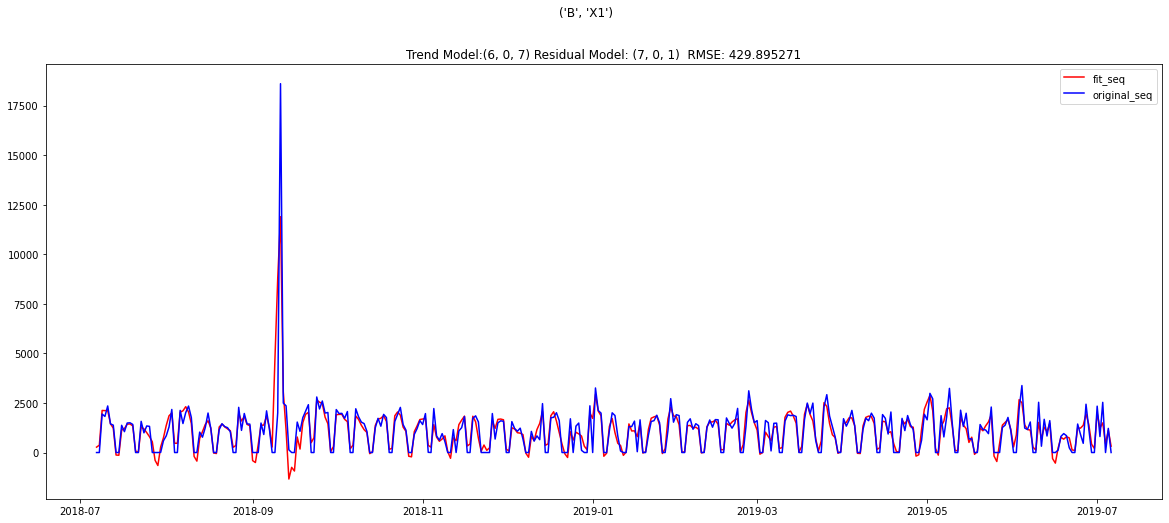

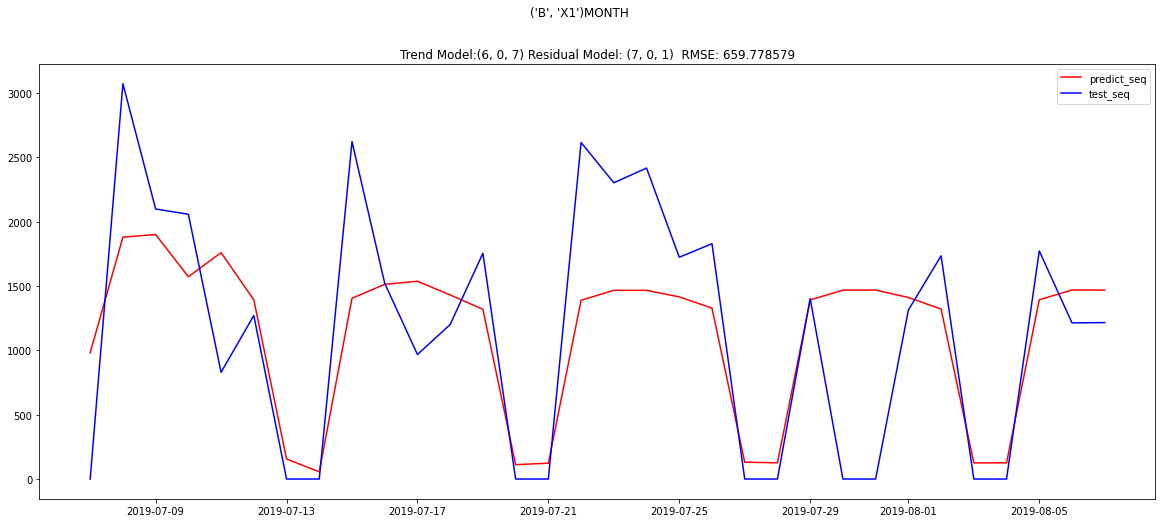

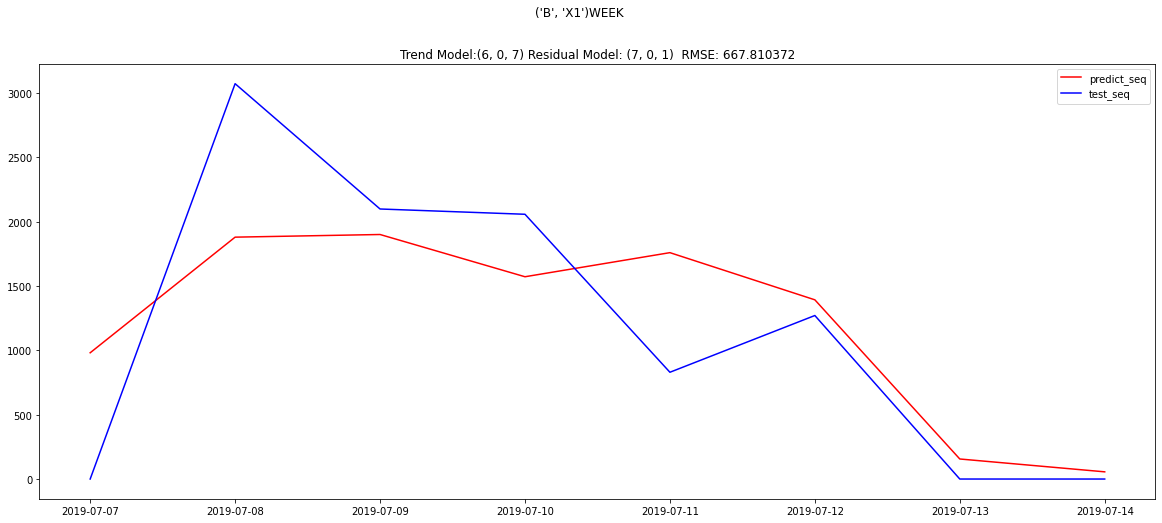

RMSE (0, 0, 0) 516.4563667347794
RMSE (0, 0, 1) 325.70781907757305
RMSE (1, 0, 0) 190.50280563162286
RMSE (1, 0, 1) 186.38792224220637
RMSE (1, 0, 2) 185.36336685361883
RMSE (1, 0, 3) 185.14060534843858
RMSE (1, 0, 4) 178.2618022359286
RMSE (1, 0, 5) 176.1425210715942
RMSE (1, 0, 6) 145.30954523939178
RMSE (1, 0, 7) 144.86153017978296
RMSE (3, 0, 6) 144.2025419622374
RMSE (4, 0, 6) 143.90141137505546
RMSE (6, 0, 6) 143.57556638369394
RMSE (0, 0, 0) 800.1559109168609
RMSE (0, 0, 1) 716.8122294134124
RMSE (0, 0, 2) 647.3545134721522
RMSE (0, 0, 3) 643.9595058220158
RMSE (1, 0, 6) 587.5166304783222
RMSE (7, 0, 5) 586.7789784735755
32


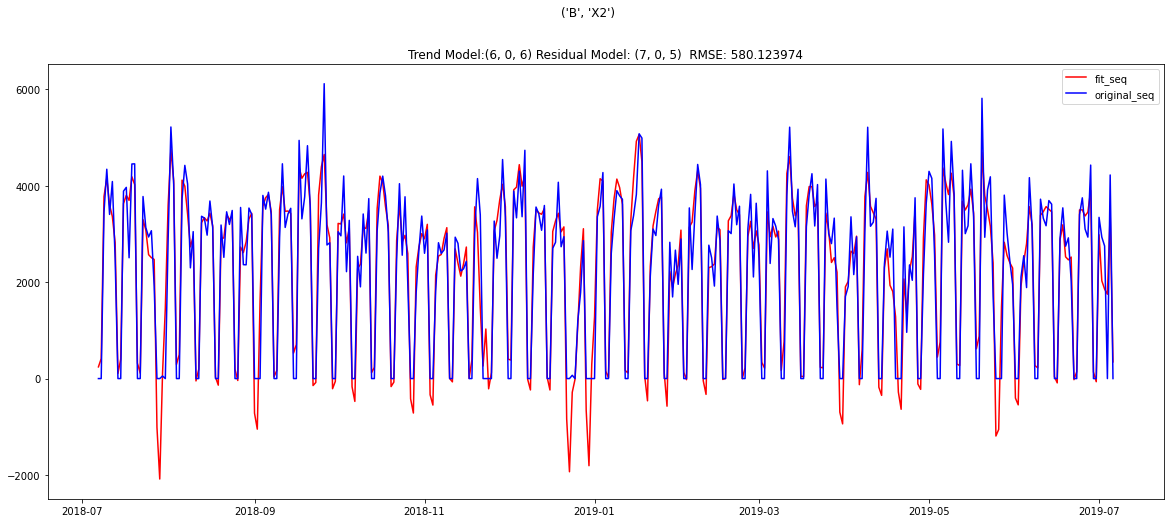

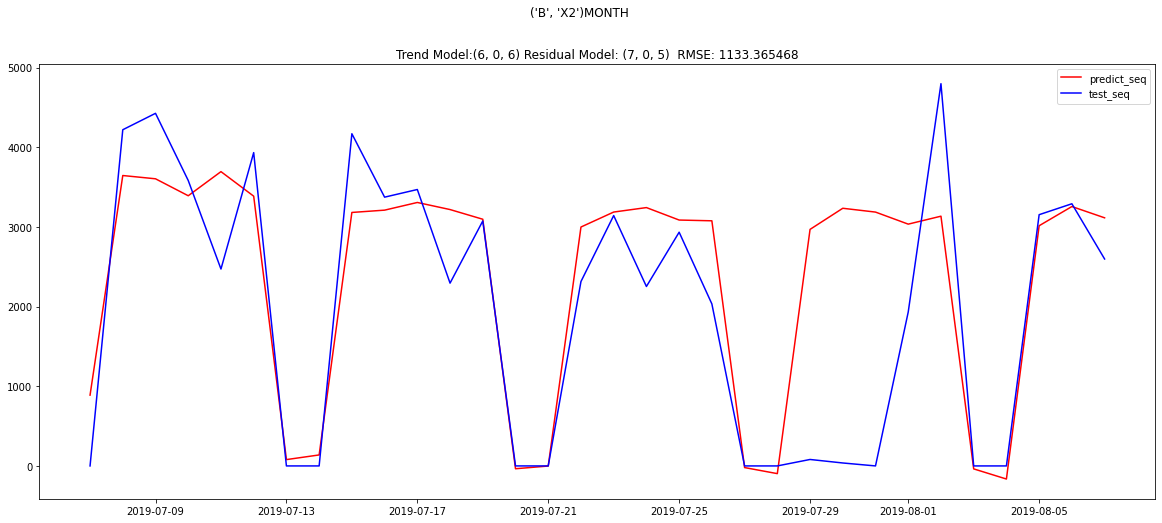

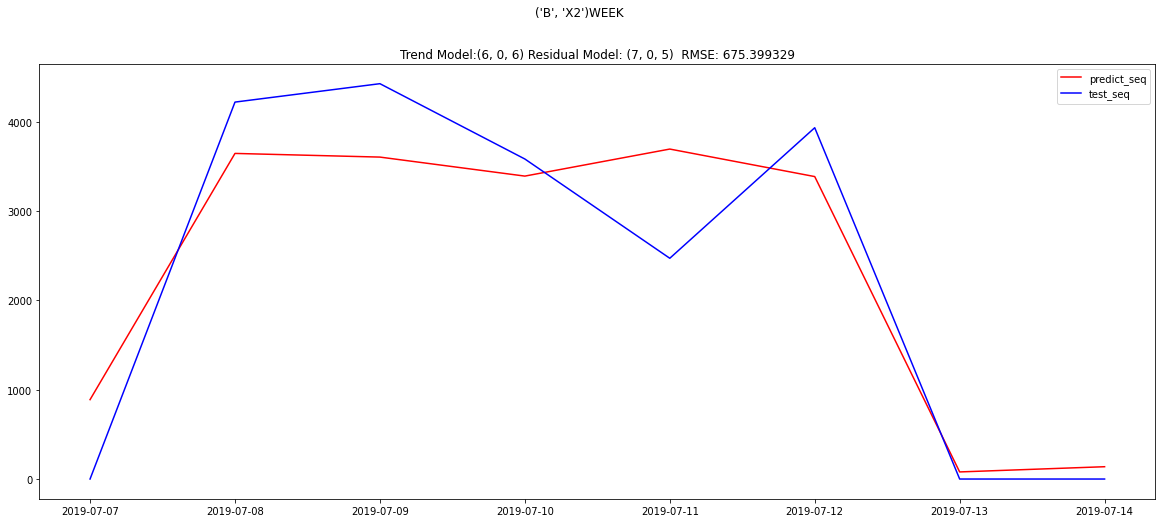

RMSE (0, 0, 0) 8.215521637618783
RMSE (0, 0, 1) 5.646157671762246
RMSE (0, 0, 3) 4.146708327433893
RMSE (0, 0, 5) 4.0961541066829525
RMSE (0, 0, 6) 2.9496214948557196
RMSE (0, 0, 7) 2.945207657725606
RMSE (1, 0, 6) 2.9450778168910103
RMSE (2, 0, 6) 2.9448496318564383
RMSE (3, 0, 6) 2.9448476480527384
RMSE (4, 0, 6) 2.944587187010482
RMSE (5, 0, 6) 2.9444616406653594
RMSE (6, 0, 6) 2.9441579393801685
RMSE (7, 0, 7) 2.9367806605928597
RMSE (0, 0, 0) 18.81119221763146
RMSE (0, 0, 1) 15.680564161494098
RMSE (0, 0, 2) 14.780580628321156
RMSE (3, 0, 1) 13.900007206712665
RMSE (7, 0, 1) 13.491865864508773
32


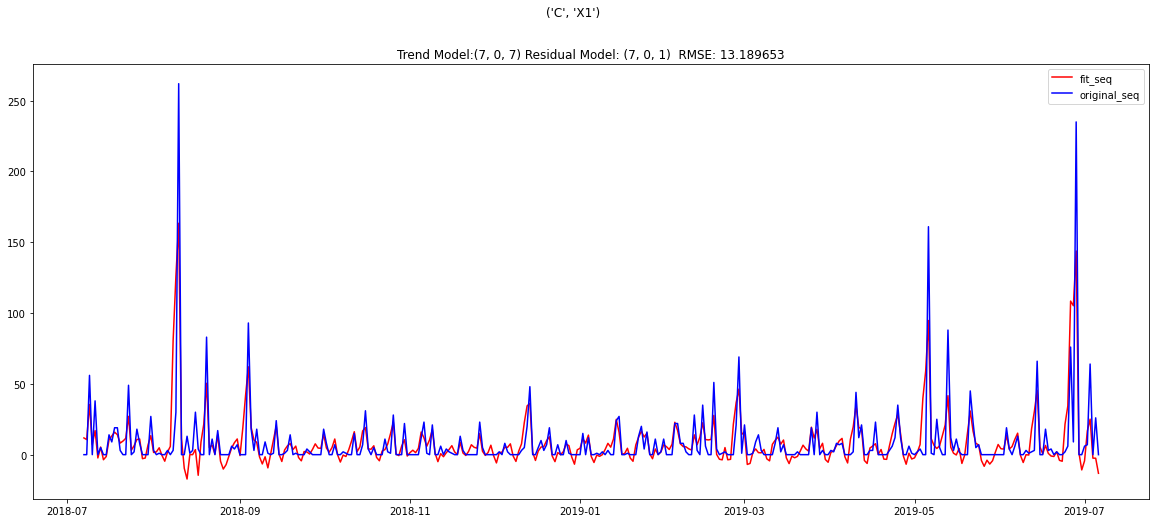

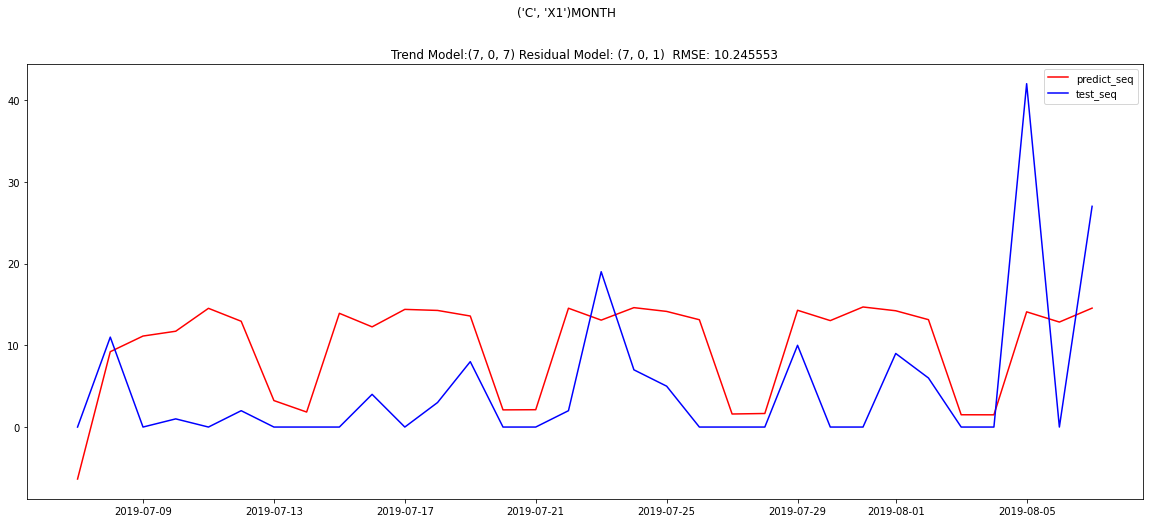

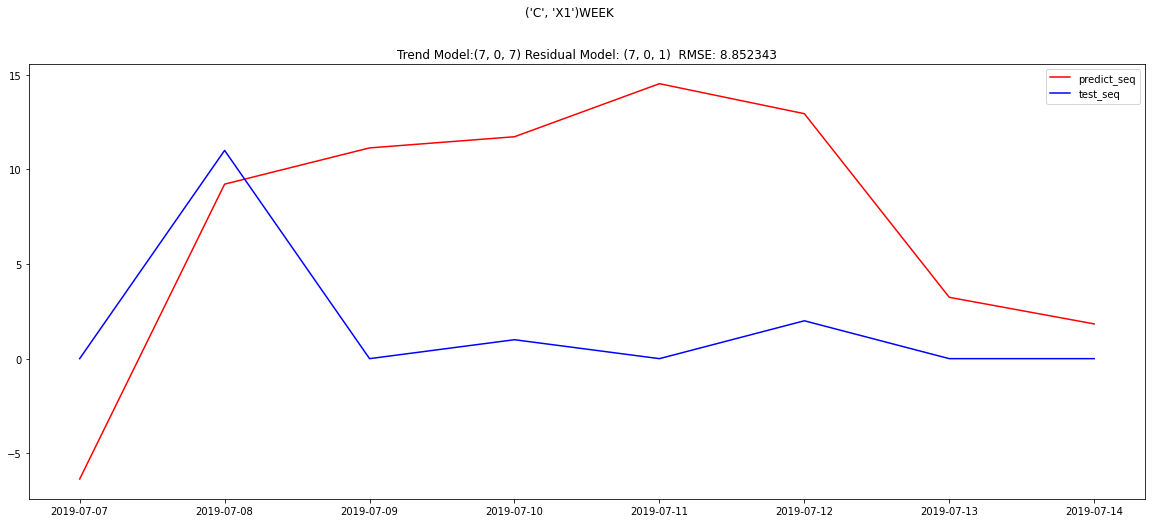

RMSE (0, 0, 0) 139.16949610476945
RMSE (0, 0, 1) 95.3367953719061
RMSE (0, 0, 3) 69.04380383557532
RMSE (0, 0, 4) 69.0436444014302
RMSE (0, 0, 5) 68.92540067114469
RMSE (0, 0, 6) 50.58226064044196
RMSE (0, 0, 7) 50.550477741221364
RMSE (1, 0, 6) 50.549349816608256
RMSE (1, 0, 7) 50.33033098474214
RMSE (2, 0, 7) 50.31774237457162
RMSE (3, 0, 7) 50.26687925674386
RMSE (0, 0, 0) 317.8650348530632
RMSE (0, 0, 1) 262.76630671588083
RMSE (0, 0, 2) 248.92153722469664
32


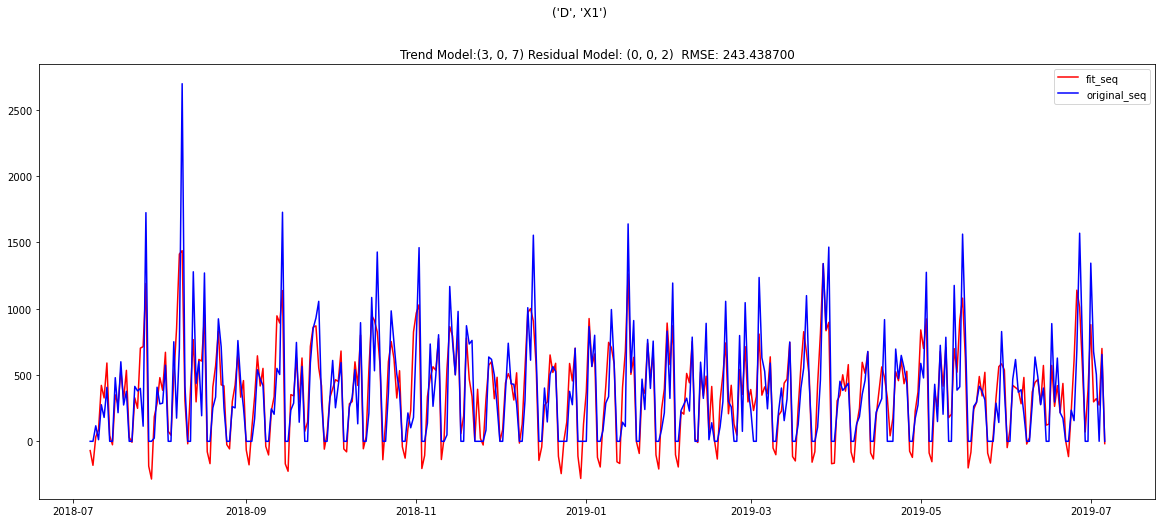

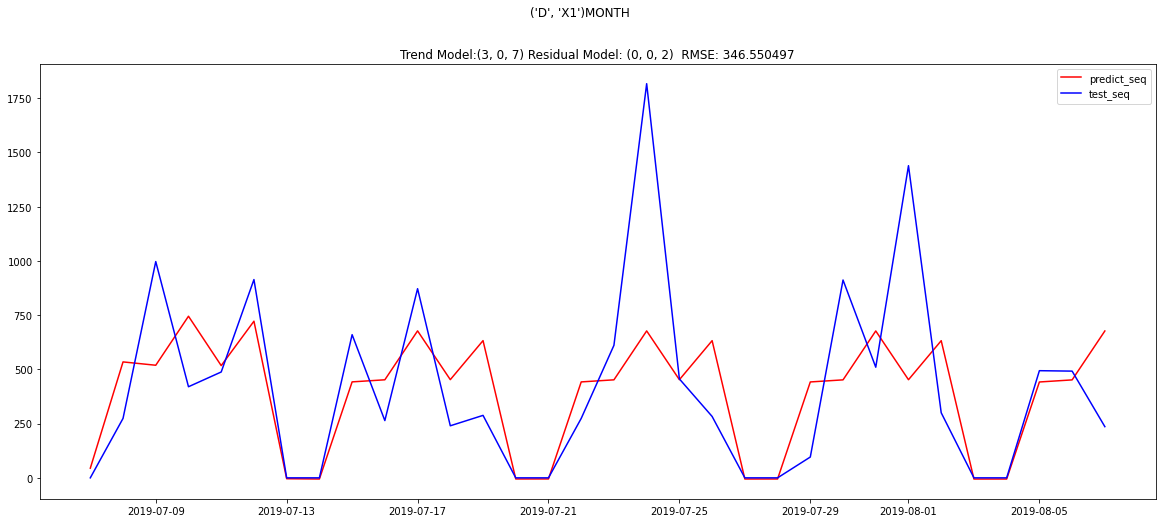

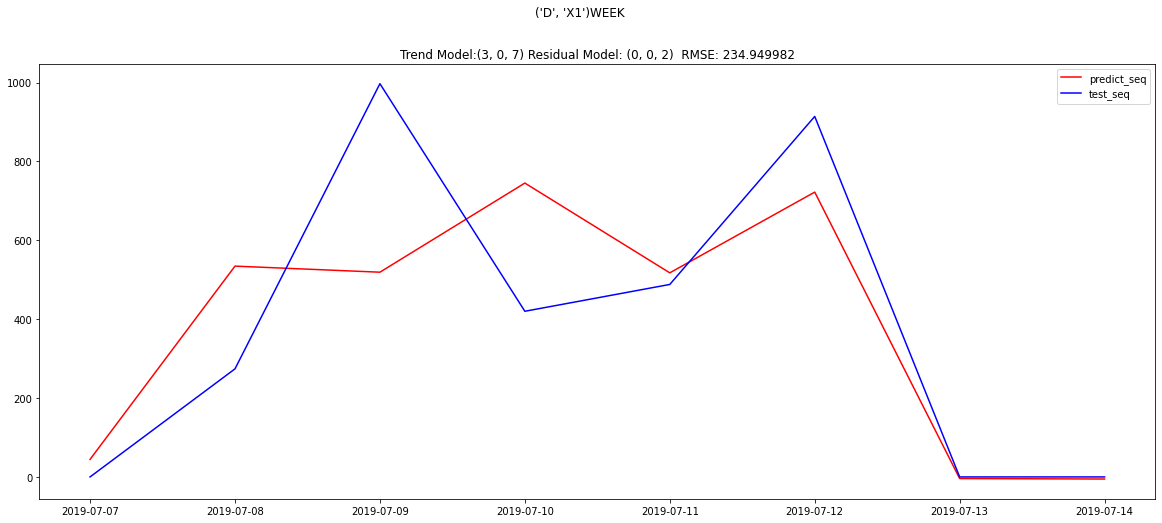

RMSE (0, 0, 0) 2161.375386637395
RMSE (0, 0, 1) 1423.7456751826858
RMSE (0, 0, 3) 988.8259520106644
RMSE (0, 0, 5) 964.5215857642768
RMSE (0, 0, 7) 698.4618500473249
RMSE (1, 0, 6) 698.1181732790096
RMSE (1, 0, 7) 684.9698346295145
RMSE (6, 0, 7) 683.5377588616367
RMSE (0, 0, 0) 4541.855771470351
RMSE (0, 0, 1) 3741.417852142799
RMSE (0, 0, 2) 3554.6042487545355
RMSE (1, 0, 7) 3115.2399813754114
RMSE (2, 0, 7) 3113.916602135728
32


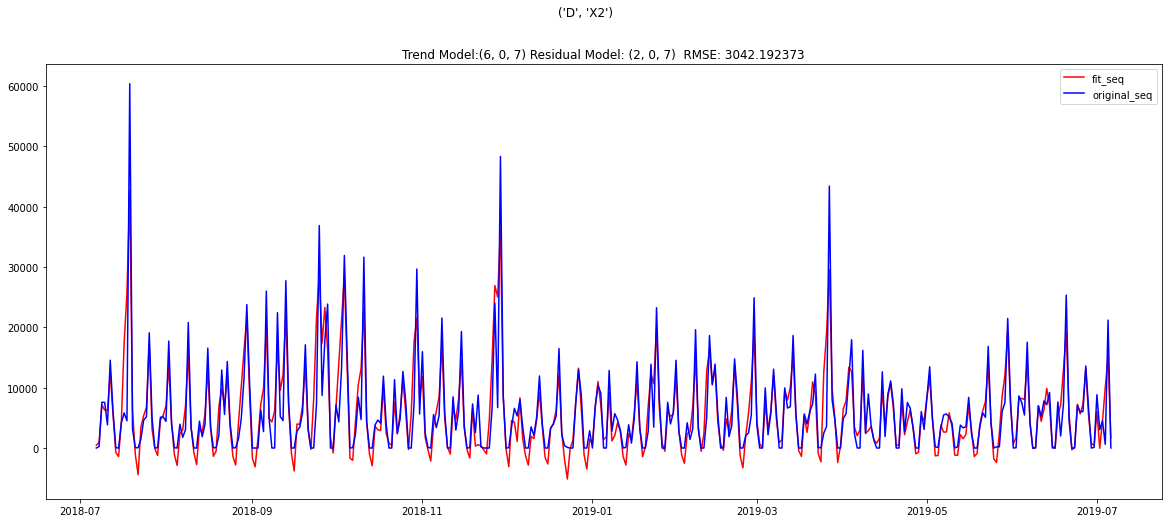

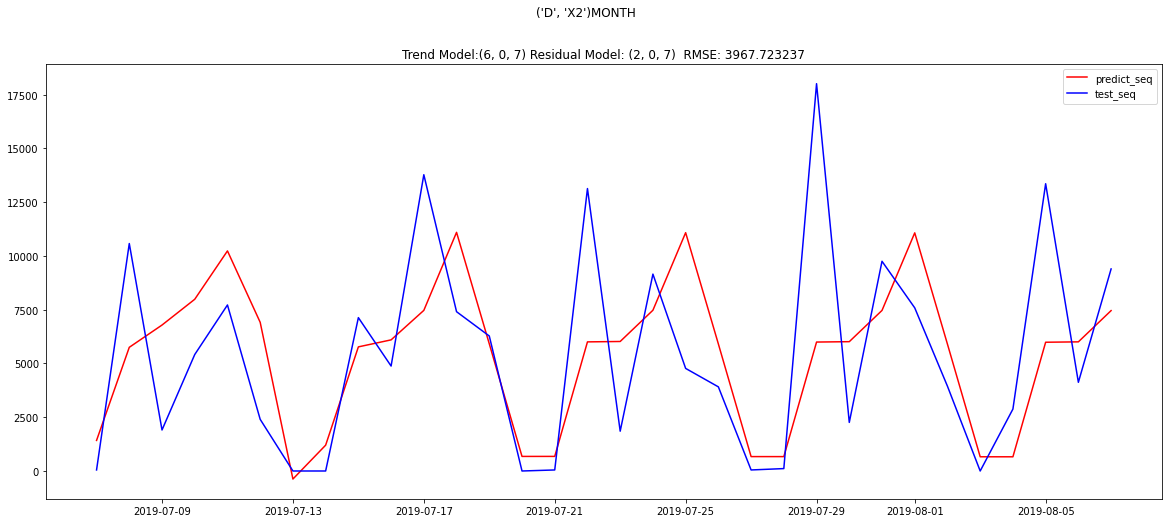

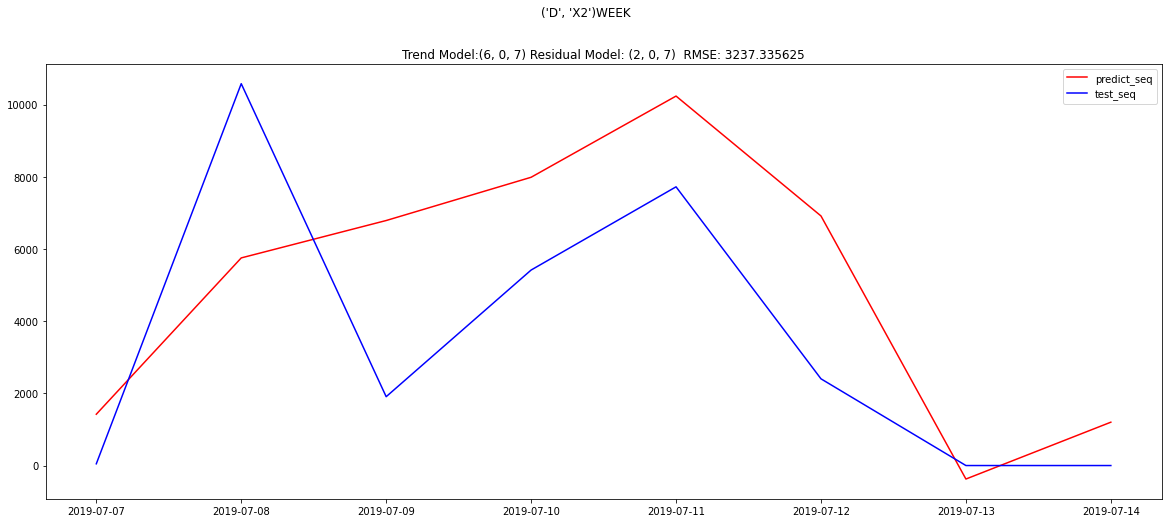

RMSE (0, 0, 0) 481.8792513314852
RMSE (0, 0, 1) 327.4418739629485
RMSE (0, 0, 3) 240.73992945996508
RMSE (0, 0, 5) 237.94948197810731
RMSE (0, 0, 7) 173.64594655880447
RMSE (1, 0, 6) 173.52396382774305
RMSE (1, 0, 7) 172.76518492425848
RMSE (2, 0, 7) 172.70712257055715
RMSE (3, 0, 7) 172.37665247439844
RMSE (5, 0, 7) 172.3162632443773
RMSE (6, 0, 7) 172.29520256614117
RMSE (0, 0, 0) 1068.8262538911406
RMSE (0, 0, 1) 890.7945101635822
RMSE (0, 0, 2) 841.8165665665101
RMSE (0, 0, 3) 841.8138521910439
RMSE (6, 0, 1) 772.4200482583606
RMSE (7, 0, 1) 771.0886964573566
32


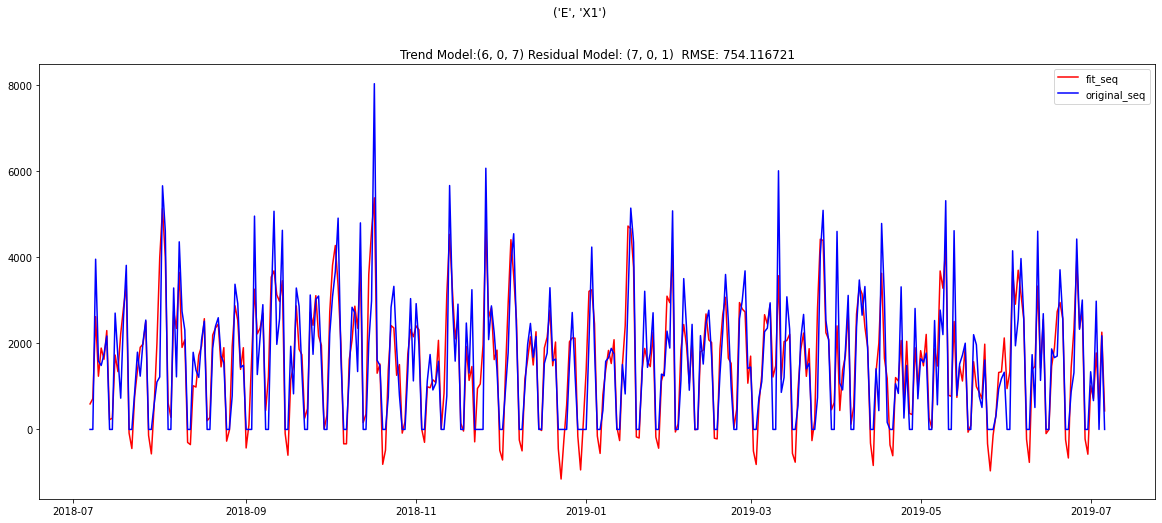

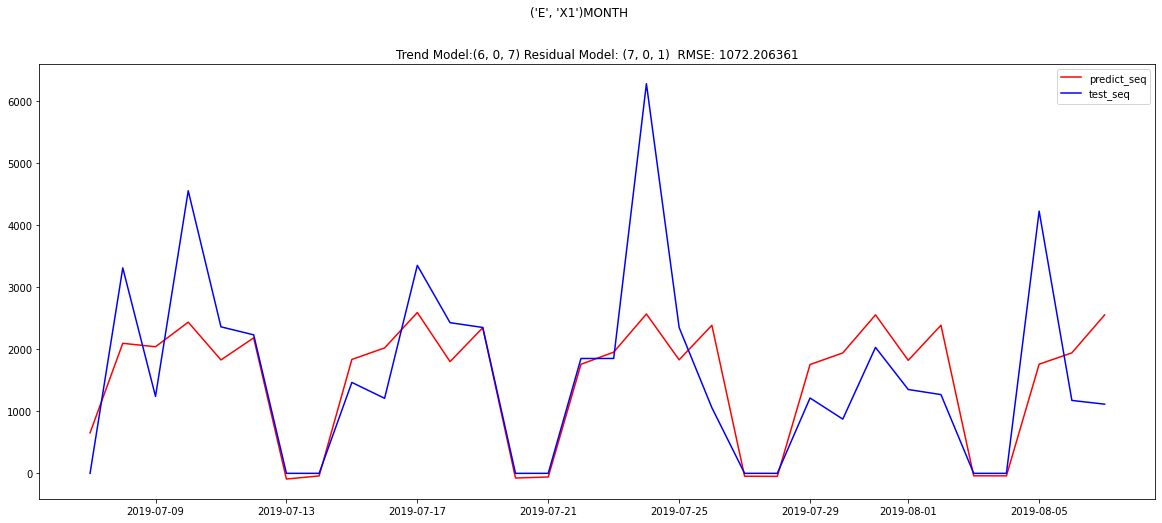

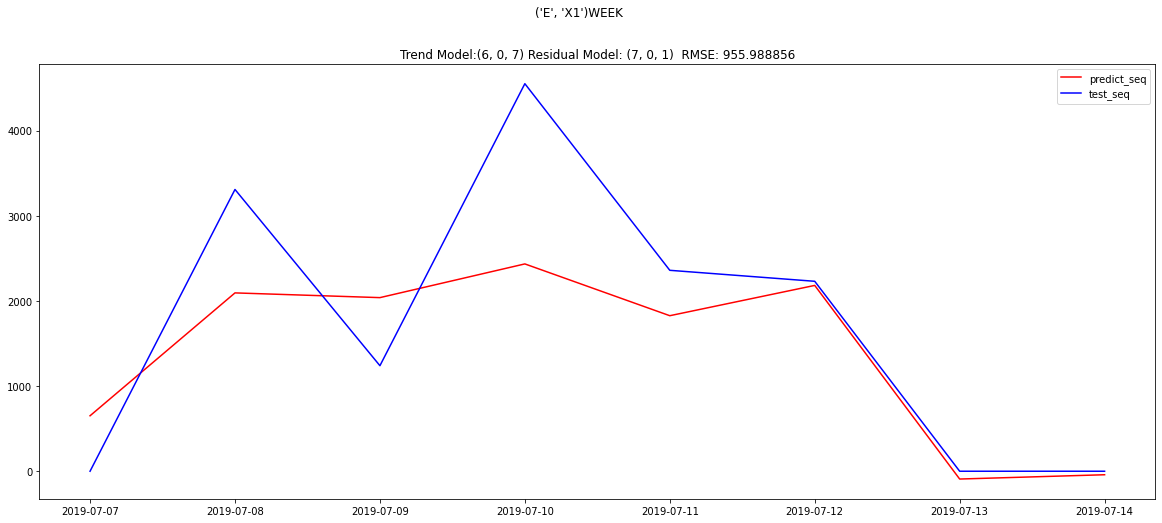

RMSE (0, 0, 0) 1850.8301528906225
RMSE (0, 0, 1) 1240.0551389675709
RMSE (0, 0, 3) 876.6735627946654
RMSE (0, 0, 5) 873.807342290591
RMSE (0, 0, 7) 661.8002447813983
RMSE (1, 0, 6) 661.581280838892
RMSE (1, 0, 7) 661.2152838989376
RMSE (2, 0, 6) 661.0336851093862
RMSE (2, 0, 7) 659.1968890558478
RMSE (7, 0, 7) 657.1433213613351
RMSE (0, 0, 0) 3854.6373219122843
RMSE (0, 0, 1) 3310.6582773402224
RMSE (0, 0, 2) 3085.483204410617
RMSE (0, 0, 3) 3080.366715089671
RMSE (1, 0, 7) 2722.7410285811065
32


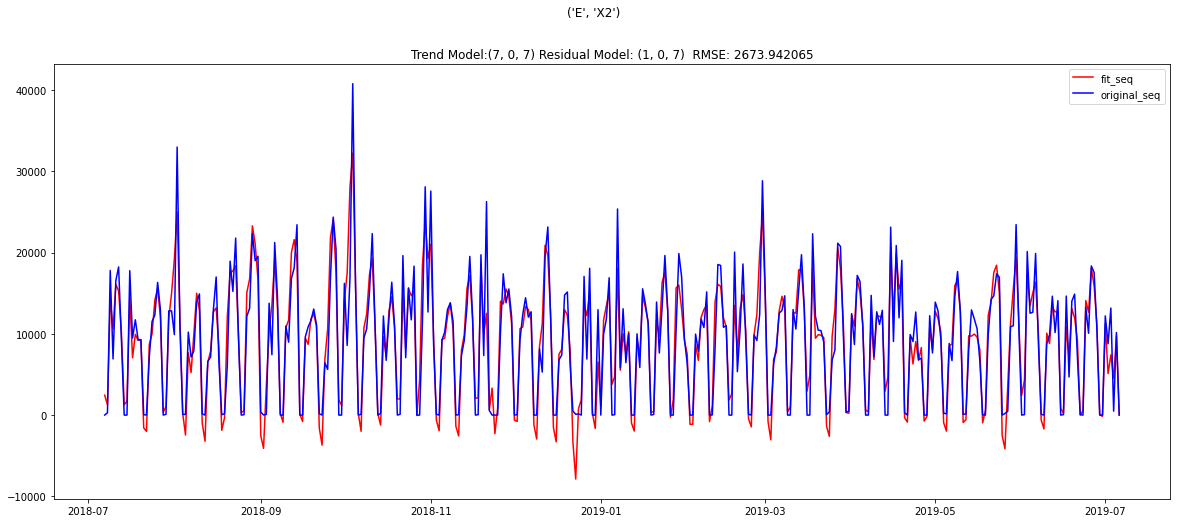

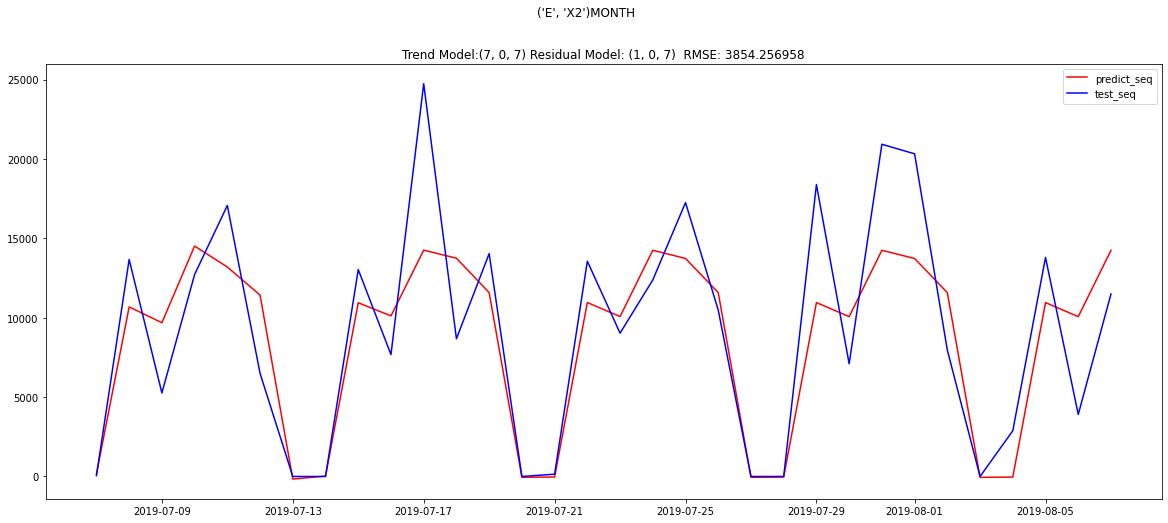

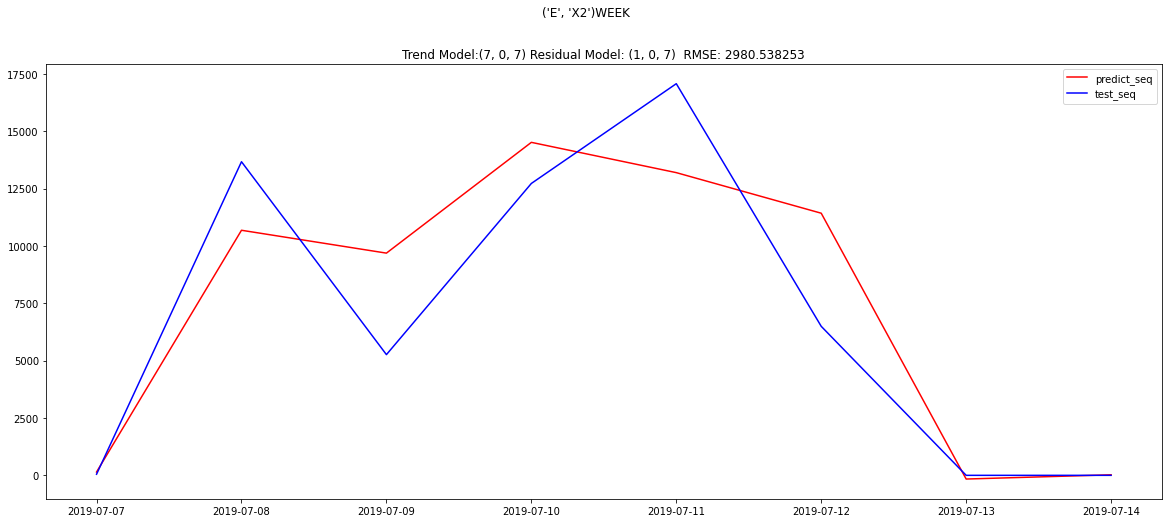

RMSE (0, 0, 0) 38.984864359266375
RMSE (0, 0, 1) 25.664963280880222
RMSE (0, 0, 3) 17.955569583371762
RMSE (0, 0, 5) 17.44608261129333
RMSE (0, 0, 7) 13.00115888494413
RMSE (1, 0, 6) 12.998140033224072
RMSE (1, 0, 7) 12.895759420499203
RMSE (2, 0, 7) 12.892423713357664
RMSE (3, 0, 7) 12.891726480061589
RMSE (4, 0, 7) 12.88858645305302
RMSE (5, 0, 7) 12.887760373026683
RMSE (6, 0, 7) 12.876675114306398
RMSE (7, 0, 6) 12.790266942647188
RMSE (0, 0, 0) 81.47949708306011
RMSE (0, 0, 1) 68.93998375312566
RMSE (0, 0, 2) 64.32330386175259
RMSE (0, 0, 3) 64.32224561357573
RMSE (1, 0, 7) 56.983253030777306
RMSE (6, 0, 2) 56.6046856553242
32


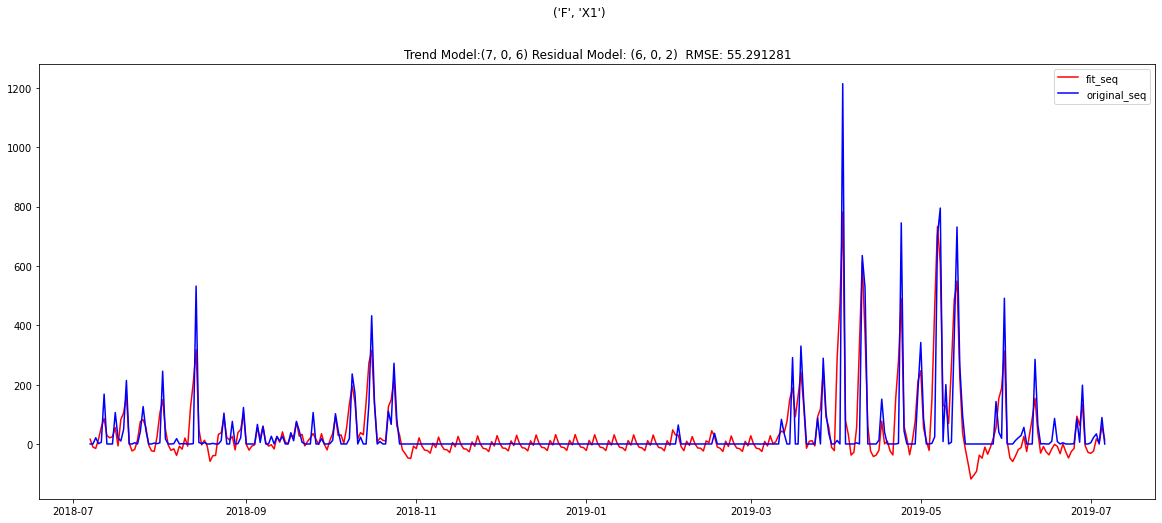

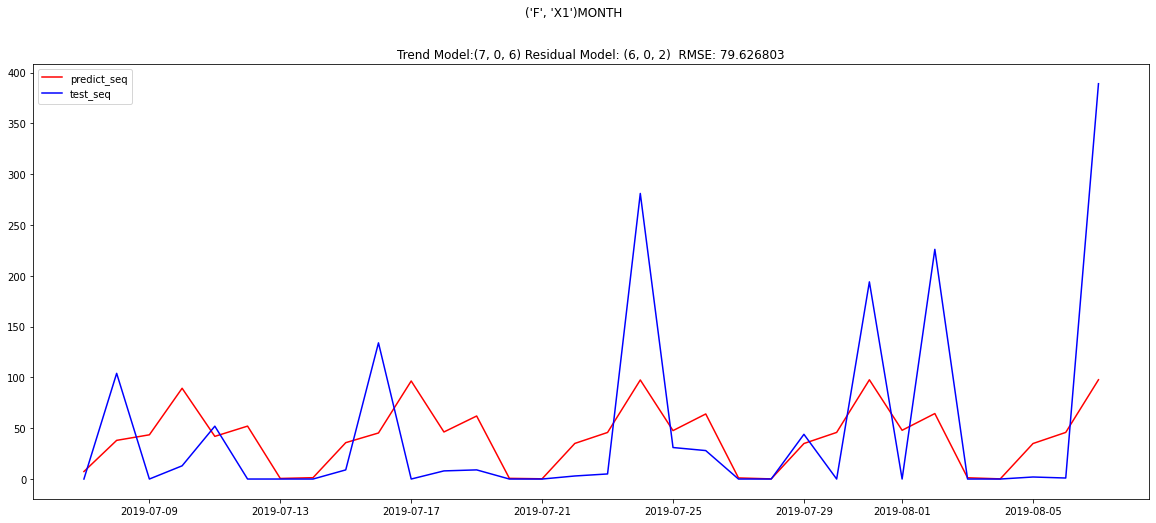

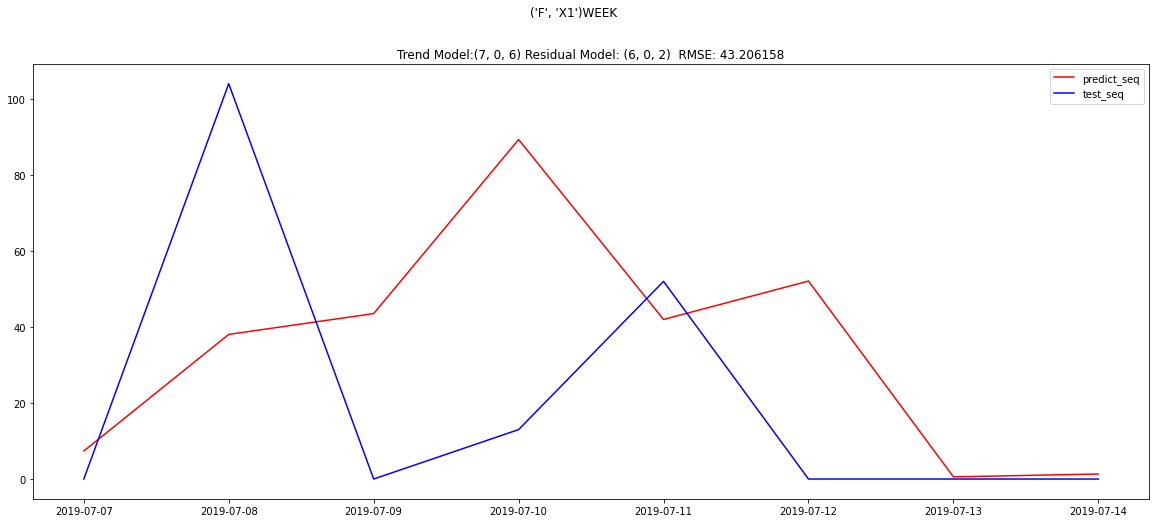

RMSE (0, 0, 0) 119.01219922670285
RMSE (0, 0, 1) 77.56120921635815
RMSE (0, 0, 5) 48.6370854776529
RMSE (1, 0, 4) 46.55815390686784
RMSE (1, 0, 5) 45.48199333260522
RMSE (1, 0, 6) 35.986508846323936
RMSE (2, 0, 6) 35.97794793062726
RMSE (2, 0, 7) 35.88126004667271
RMSE (3, 0, 7) 35.87815009967636
RMSE (4, 0, 7) 35.87445023110191
RMSE (7, 0, 6) 35.8623664558073
RMSE (0, 0, 0) 226.37058049656818
RMSE (0, 0, 1) 198.69972943416067
RMSE (0, 0, 2) 180.4152396330637
RMSE (0, 0, 3) 179.5956937285831
RMSE (3, 0, 1) 168.30905359254004
RMSE (5, 0, 1) 165.6343602204867
32


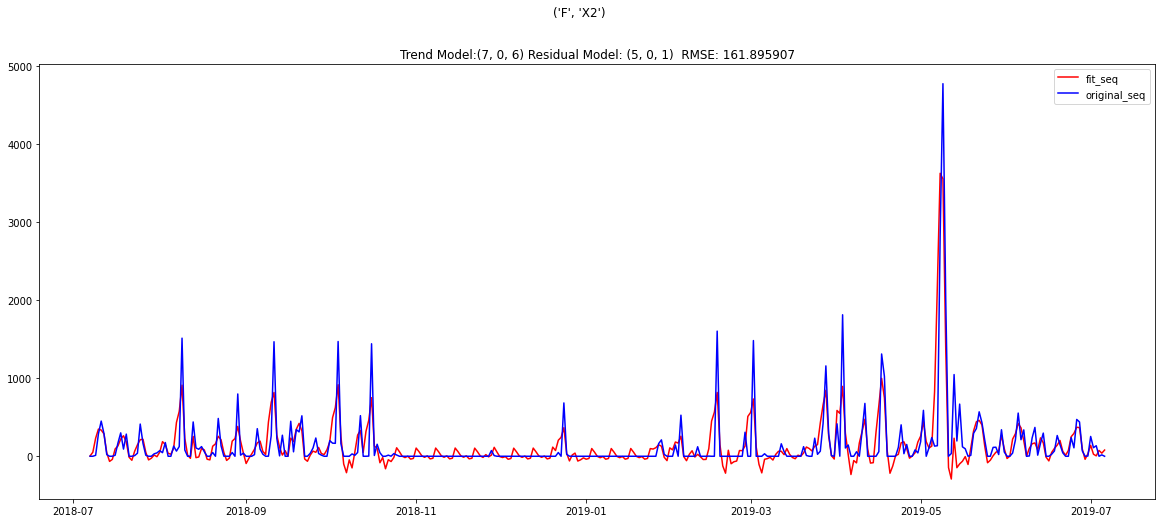

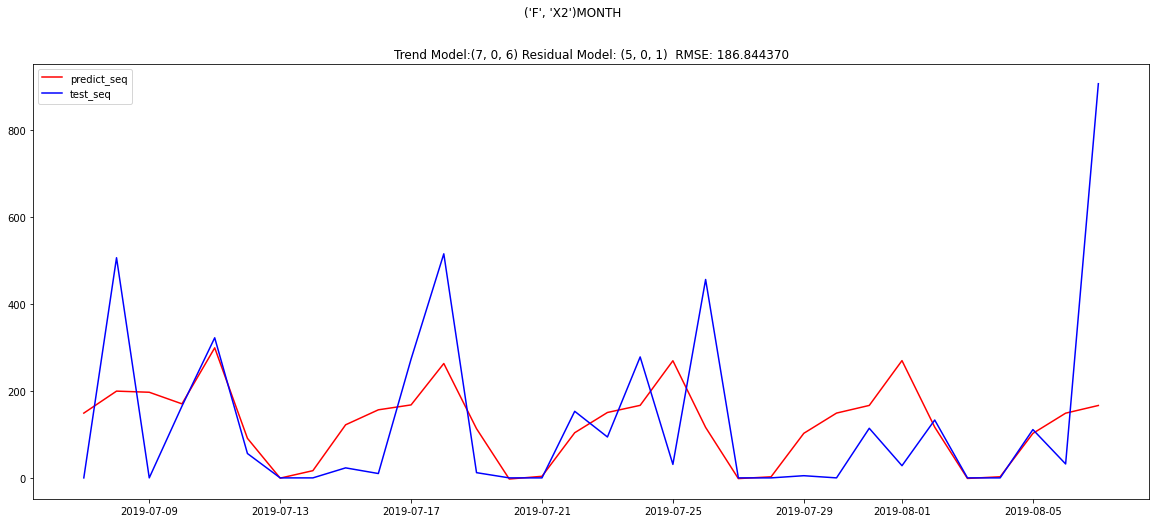

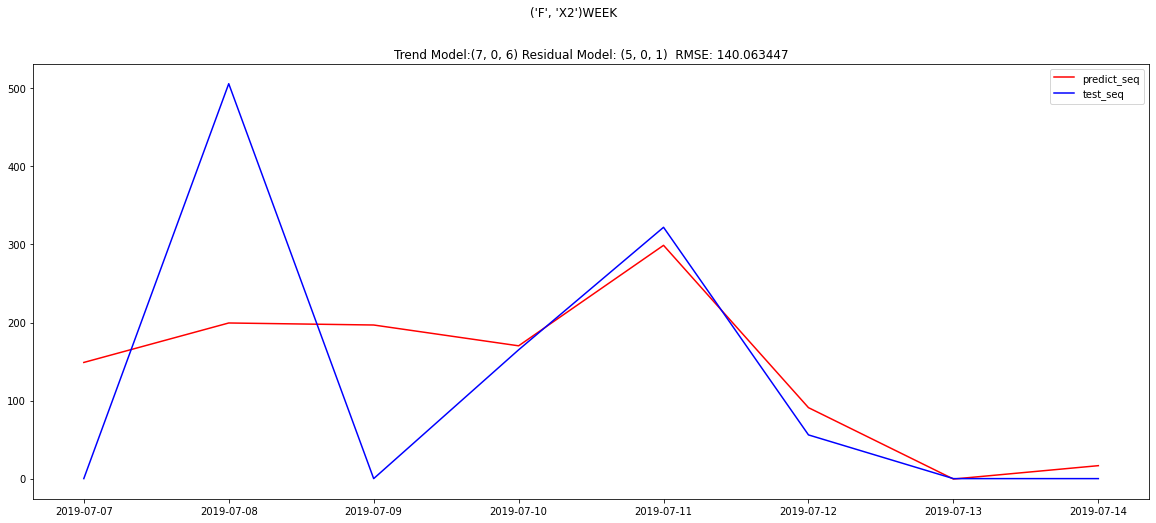

RMSE (0, 0, 0) 112.42542463985198
RMSE (0, 0, 1) 82.31058280488794
RMSE (0, 0, 2) 72.83475943975495
RMSE (0, 0, 3) 65.2710319002088
RMSE (0, 0, 4) 64.46972066704178
RMSE (0, 0, 5) 64.22935063394901
RMSE (0, 0, 6) 46.76202578114549
RMSE (0, 0, 7) 46.72650946351835
RMSE (1, 0, 7) 46.64841093673756
RMSE (2, 0, 7) 46.64755164510611
RMSE (3, 0, 7) 46.632002491647256
RMSE (4, 0, 7) 46.63109186083673
RMSE (5, 0, 7) 46.625234739012896
RMSE (6, 0, 7) 46.57388818870761
RMSE (7, 0, 6) 46.53950975823133
RMSE (0, 0, 0) 307.7085786875868
RMSE (0, 0, 1) 250.3836865303064
RMSE (0, 0, 2) 239.6275383865145
RMSE (7, 0, 1) 218.0095968653304
32


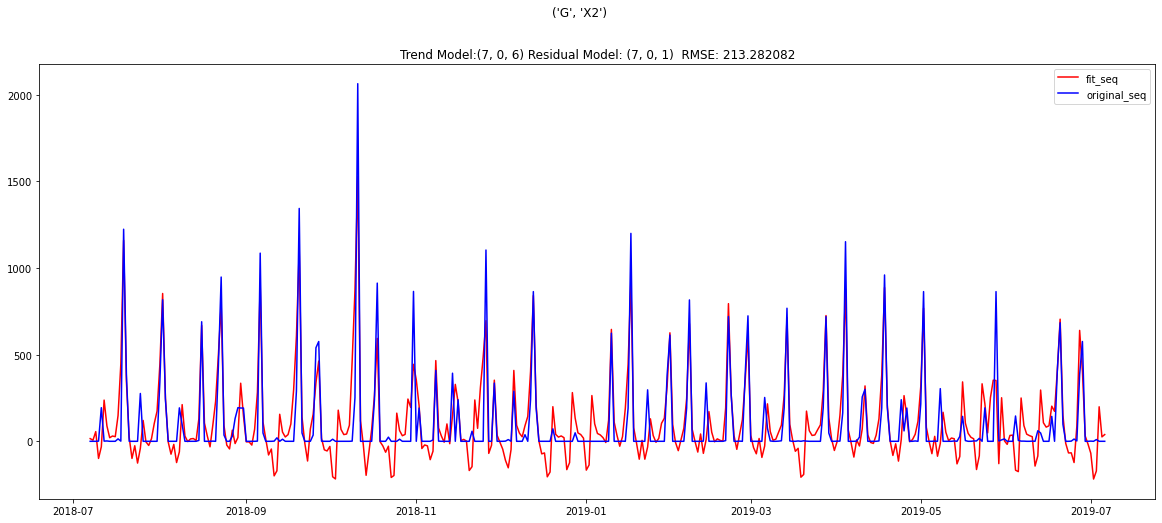

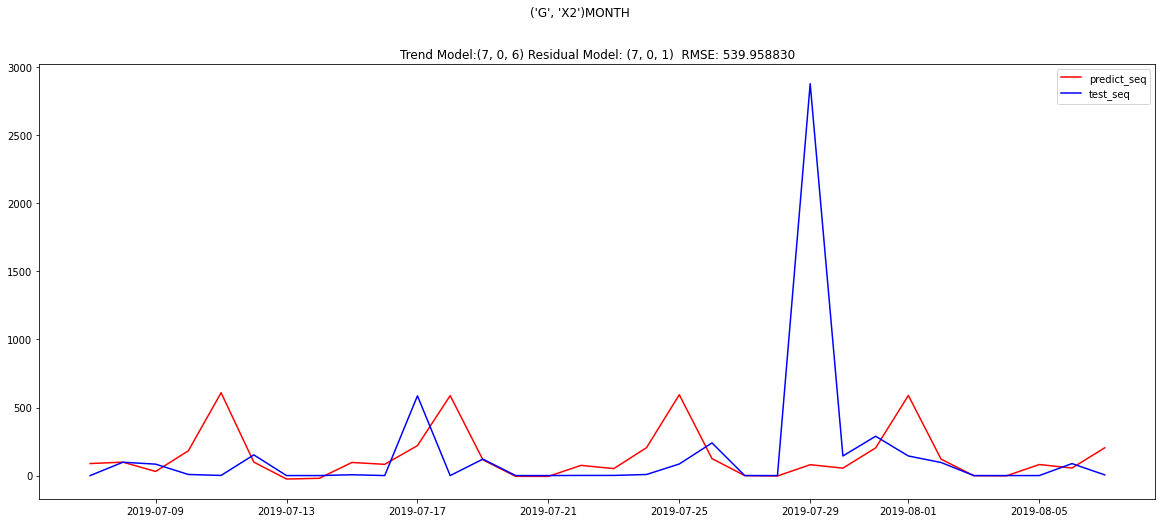

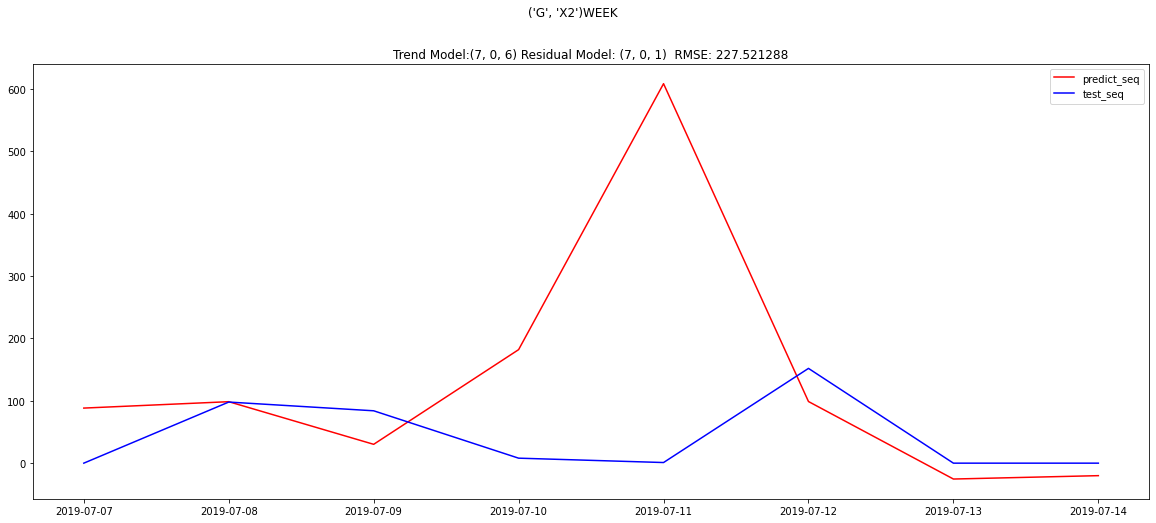

RMSE (0, 0, 0) 34.521263819768436
RMSE (0, 0, 1) 22.798042504947475
RMSE (0, 0, 3) 15.410830869507665
RMSE (0, 0, 5) 15.088270552354166
RMSE (0, 0, 6) 10.994871066804718
RMSE (0, 0, 7) 10.899234767517521
RMSE (1, 0, 6) 10.887409630827406
RMSE (1, 0, 7) 10.858808717791812
RMSE (2, 0, 7) 10.83768106884627
RMSE (3, 0, 7) 10.834544394125455
RMSE (4, 0, 7) 10.829445400603895
RMSE (6, 0, 7) 10.825953301722226
RMSE (0, 0, 0) 66.82533789579547
RMSE (0, 0, 1) 57.748454404179576
RMSE (0, 0, 2) 53.42941836419078
RMSE (0, 0, 3) 53.288492575577386
RMSE (3, 0, 1) 50.220461078690064
RMSE (7, 0, 1) 49.29723606646133
32


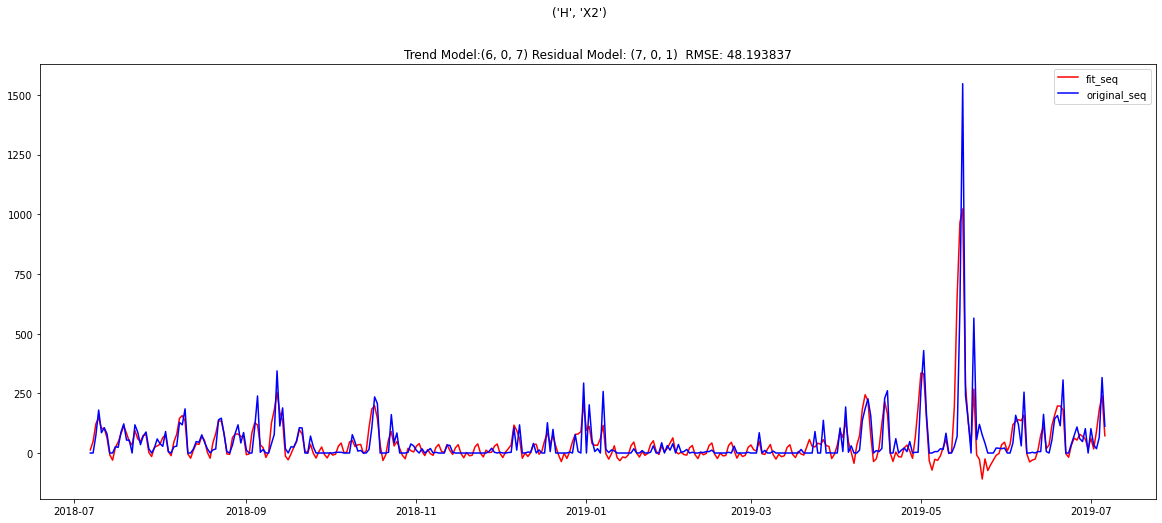

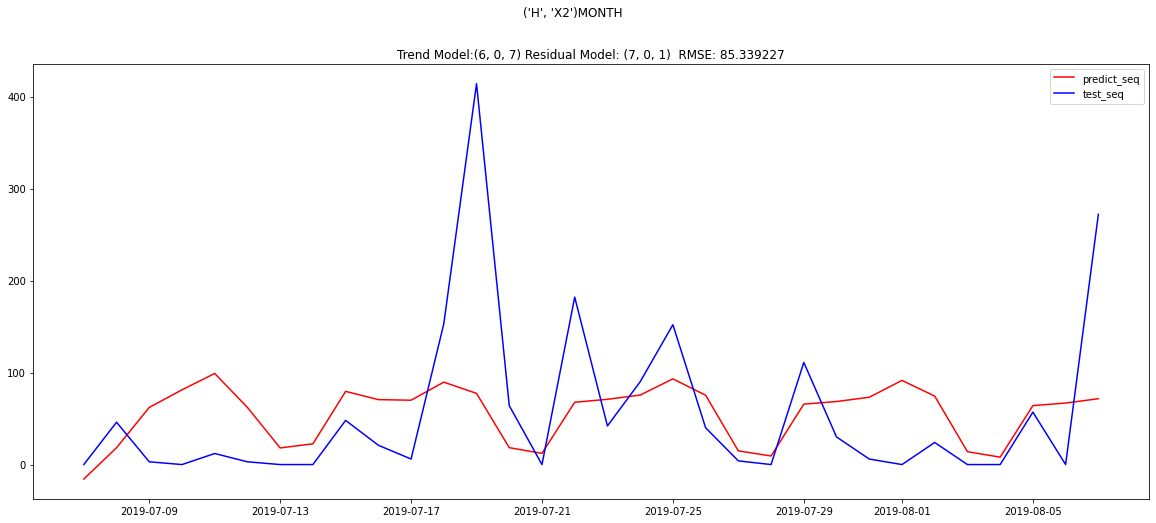

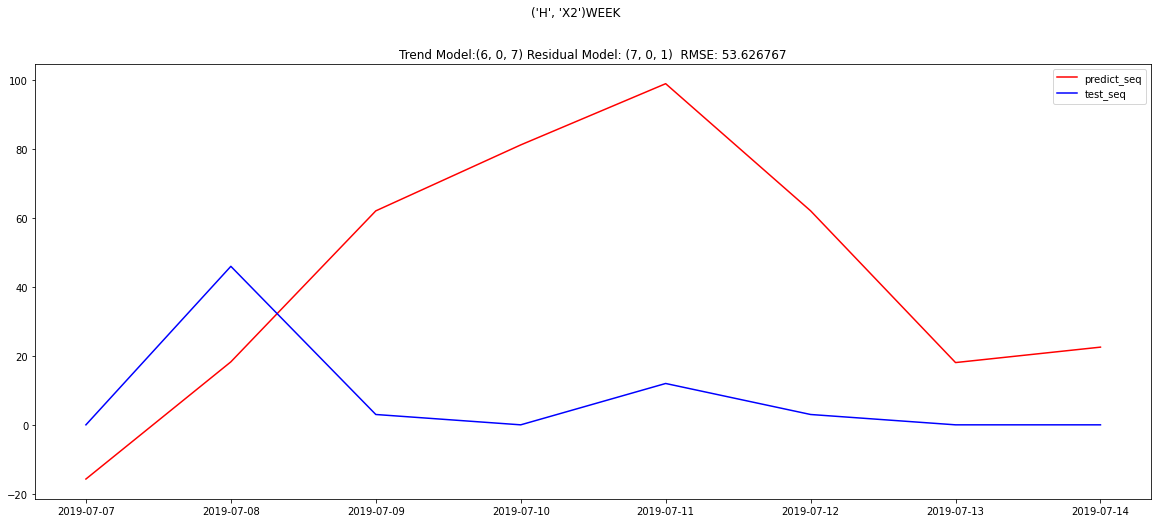

In [ ]:
residual_pdq=list()
trend_pdq=list()
index=0
residual_pdq=list()
trend_pdq=list()
model_info=pd.DataFrame(columns=['Label','Trend','Residual','Simulation_RMSE','Month_RMSE','Week_RMSE','Simulation_WAPE','Month_WAPE','Week_WAPE'])
index=0

for label,df in groups:
  if index<0:
    print(label)
    pass
  else:
    train_size=int(len(df)*0.9)
    
    data=df.iloc[:,2].astype('int').reset_index()

    data=df.iloc[:,2].astype('int').reset_index()
    work=workday.reset_index()
    df1=pd.concat([data,work],axis=1).iloc[:,1:]
    df1.set_index('DATE',inplace=True)
    df1.index.name=None
    data=df1.iloc[:,0]

    series=log(data)



    #series=log(data)

    series=data
    series.index=data.index.astype('datetime64[ns]')
    train=series[0:train_size]
    test=series[train_size:]

    decomposition = seasonal_decompose(series)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    trend = trend.fillna(0)
    seasonal = seasonal.fillna(0)
    residual = residual.fillna(0)

    tr_pdq=gridsearch(trend)
    re_pdq=gridsearch(residual)

    trend_pdq.append(tr_pdq)
    residual_pdq.append(re_pdq)
    
    fit_seq,pre_seq=model_fit(seasonal,trend,residual,tr_pdq,re_pdq)
    
    #recover the log sequence
    #fit_seq=recover(month_fit_seq)
    #pre_seq=recover(month_pre_seq)

    rs,ws=fit_plot(fit_seq,label,data[0:train_size],tr_pdq,re_pdq)
    rm,wm=pre_month(pre_seq,label,data[train_size:],tr_pdq,re_pdq)
    rw,ww=pre_week(pre_seq[0:8],label,data[train_size:],tr_pdq,re_pdq)

    model_info.loc[index]=[label,tr_pdq,re_pdq,rs,rm,rw,ws,wm,ww]

    #recover the log sequence
    #week_fit_seq=recover(week_fit_seq)
    # week_pre_seq=recover(week_pre_seq)

    #plt.figure(figsize=(12, 6))
    #plt.plot(seasonal,label='Seasonarity')#all are 7
    #residual_p,residual_d,residual_q,residual_aic=gridsearch(residual)
  index+=1

In [ ]:
model_info.to_csv('/content/drive/MyDrive/Colab Notebooks/LSE/Capstone/Model_info/ARIMAX(workday).csv')